In [1]:
"""
General imports and loading of the audio file for development and explorative research.
The audio signal is normalized in the time domain to its highest value.
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
%run transient_shaper_lib.ipynb

SAMPLE_LENGTH = 10

def read_audio_files(directory):
  """
  Reads all audio files from a directory and returns their data with file name labels.

  Args:
      directory: The directory path (string).

  Returns:
      A list of tuples, where each tuple contains:
          - The audio data as a NumPy array.
          - The filename (without extension).
  """

  audio_data_list = []
  for filename in os.listdir(directory):
    if filename.endswith(".wav"):  # Check for .wav files
        filepath = os.path.join(directory, filename)
        sample_rate, audio_data = sp.io.wavfile.read(filepath)
        try:
          audio_data = audio_data[:, 0]
        except:
          pass
        n_bits = 32  # Assuming 32-bit audio
        audio_data = audio_data / (2**(n_bits - 1))  # Adjust range to -1 to 1 
        audio_data /= np.abs(np.max(audio_data))  # Safer normalization
        audio_data = audio_data[: sample_rate * SAMPLE_LENGTH]
        label = os.path.splitext(filename)[0]  # Extract filename without extension
        audio_data_list.append((audio_data, label, sample_rate))

  return audio_data_list

audio_data_with_labels = read_audio_files(os.getcwd())

print("Audio data and labels:")
for audio_data, label, sample_rate in audio_data_with_labels:
  print(f"- Label: {label}, Audio data shape: {audio_data.shape}, Sample rate: {sample_rate}")

FRAME_LEN = 1   # in s


Audio data and labels:
- Label: 1, Audio data shape: (371824,), Sample rate: 96000
- Label: 11 - Vocal A, Audio data shape: (315851,), Sample rate: 96000
- Label: 13 - Eli Preiss - Alles und nichts, Audio data shape: (585468,), Sample rate: 96000
- Label: 14 - 20221106_GNOSSIENNE No. 1 on GUITAR! (Erik Satie), Audio data shape: (452350,), Sample rate: 96000
- Label: 21 - 20230323_100 gecs - Dumbest girl alive lyrics video, Audio data shape: (307926,), Sample rate: 96000
- Label: 23 - 20220811_Westberlin Bass, Audio data shape: (614763,), Sample rate: 96000
- Label: 26 - Jorja Smith - Teenage Fantasy, Audio data shape: (491054,), Sample rate: 96000
- Label: 7 - 330744__alonnaallen__90s-beat-loop-140bpm, Audio data shape: (246743,), Sample rate: 96000
- Label: asdf, Audio data shape: (371525,), Sample rate: 96000


1
Tempo:  123.96694214876032
TA1:  0.012270833333333333
TA2:  0.22586458333333334
-------
TA1 python percentile:  0.012684895833333333
TA2 python percentile::  0.22597135416666667


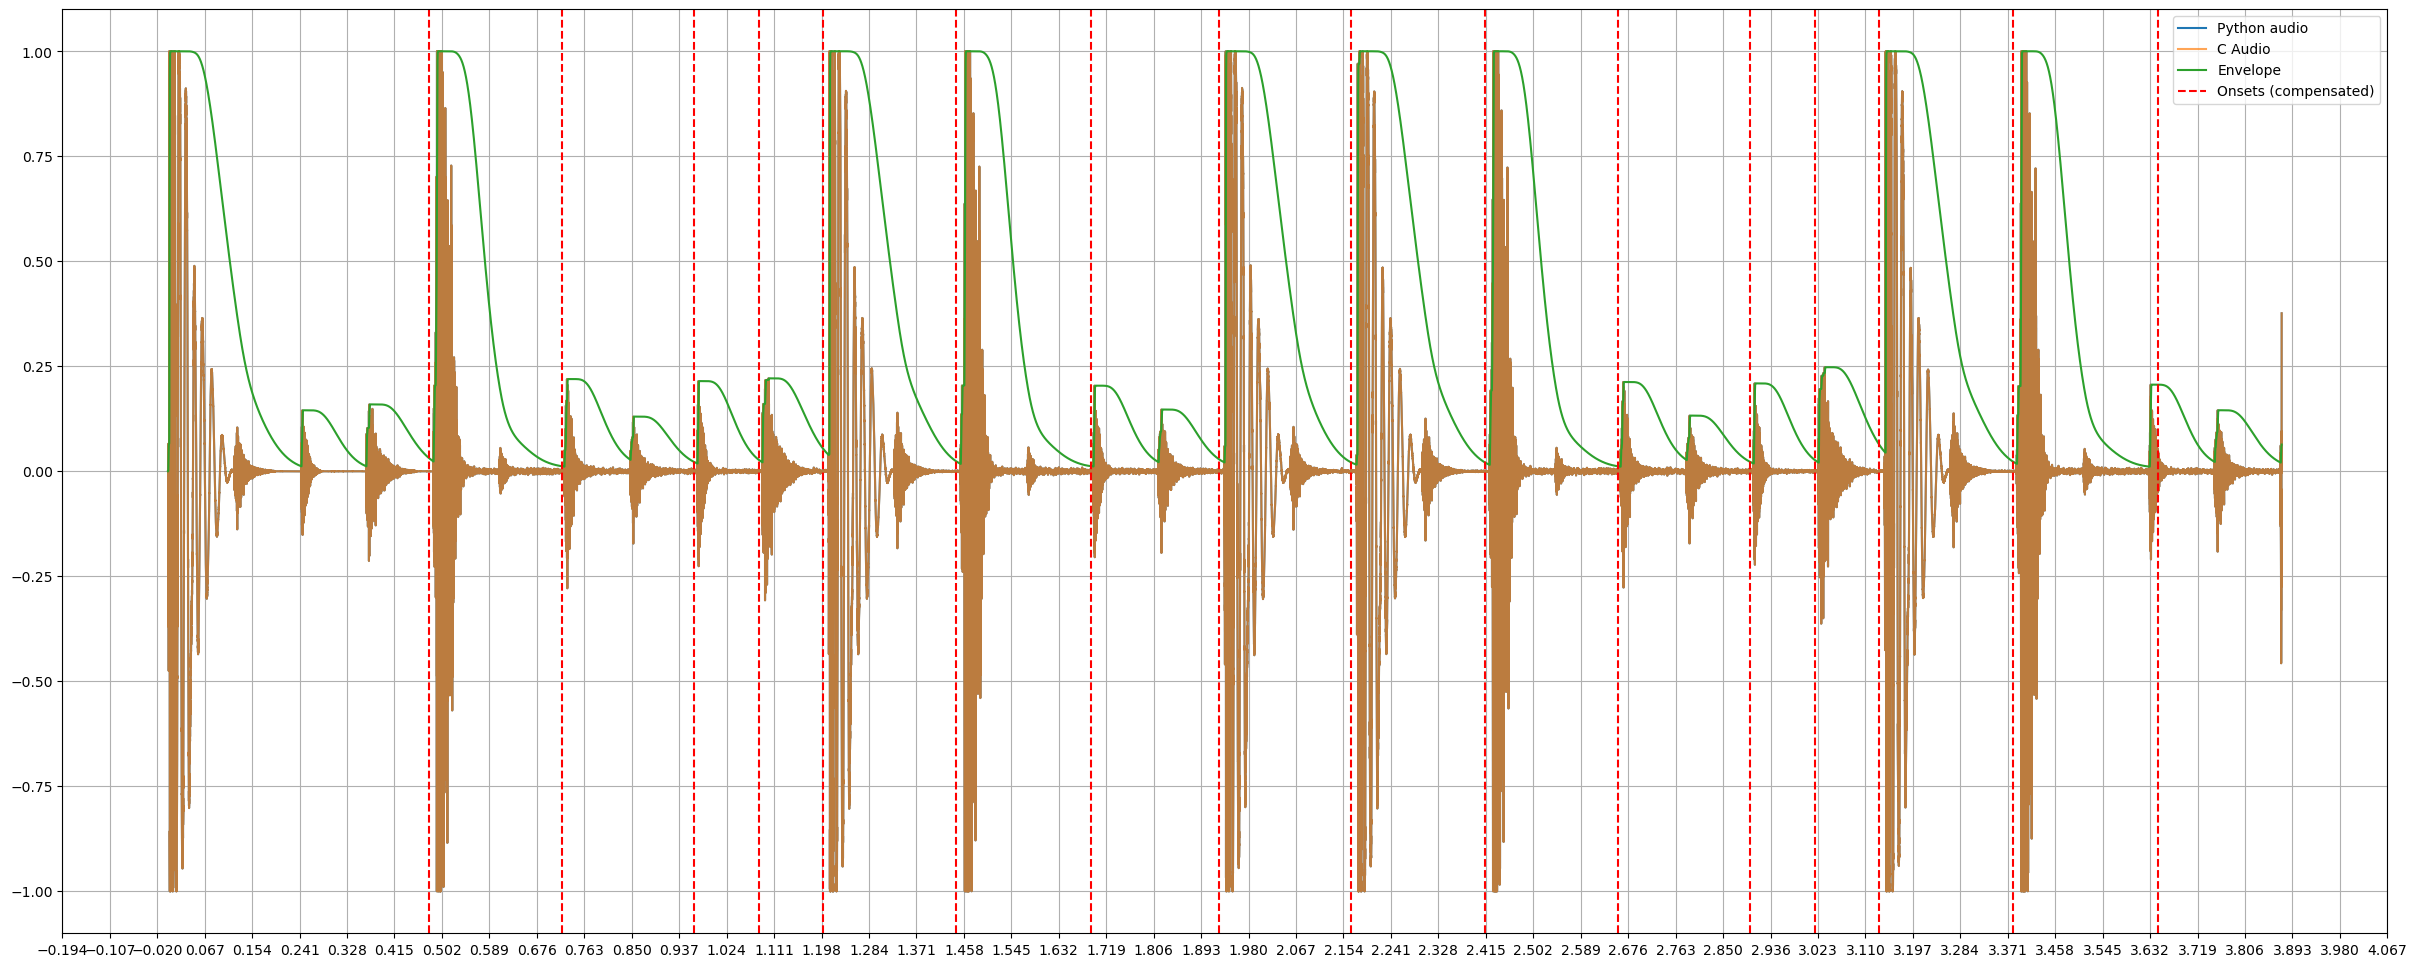

11 - Vocal A
Tempo:  117.49347258485639
TA1:  0.040864583333333336
TA2:  0.31002083333333336
-------
TA1 python percentile:  0.030453125
TA2 python percentile::  0.22715104166666666


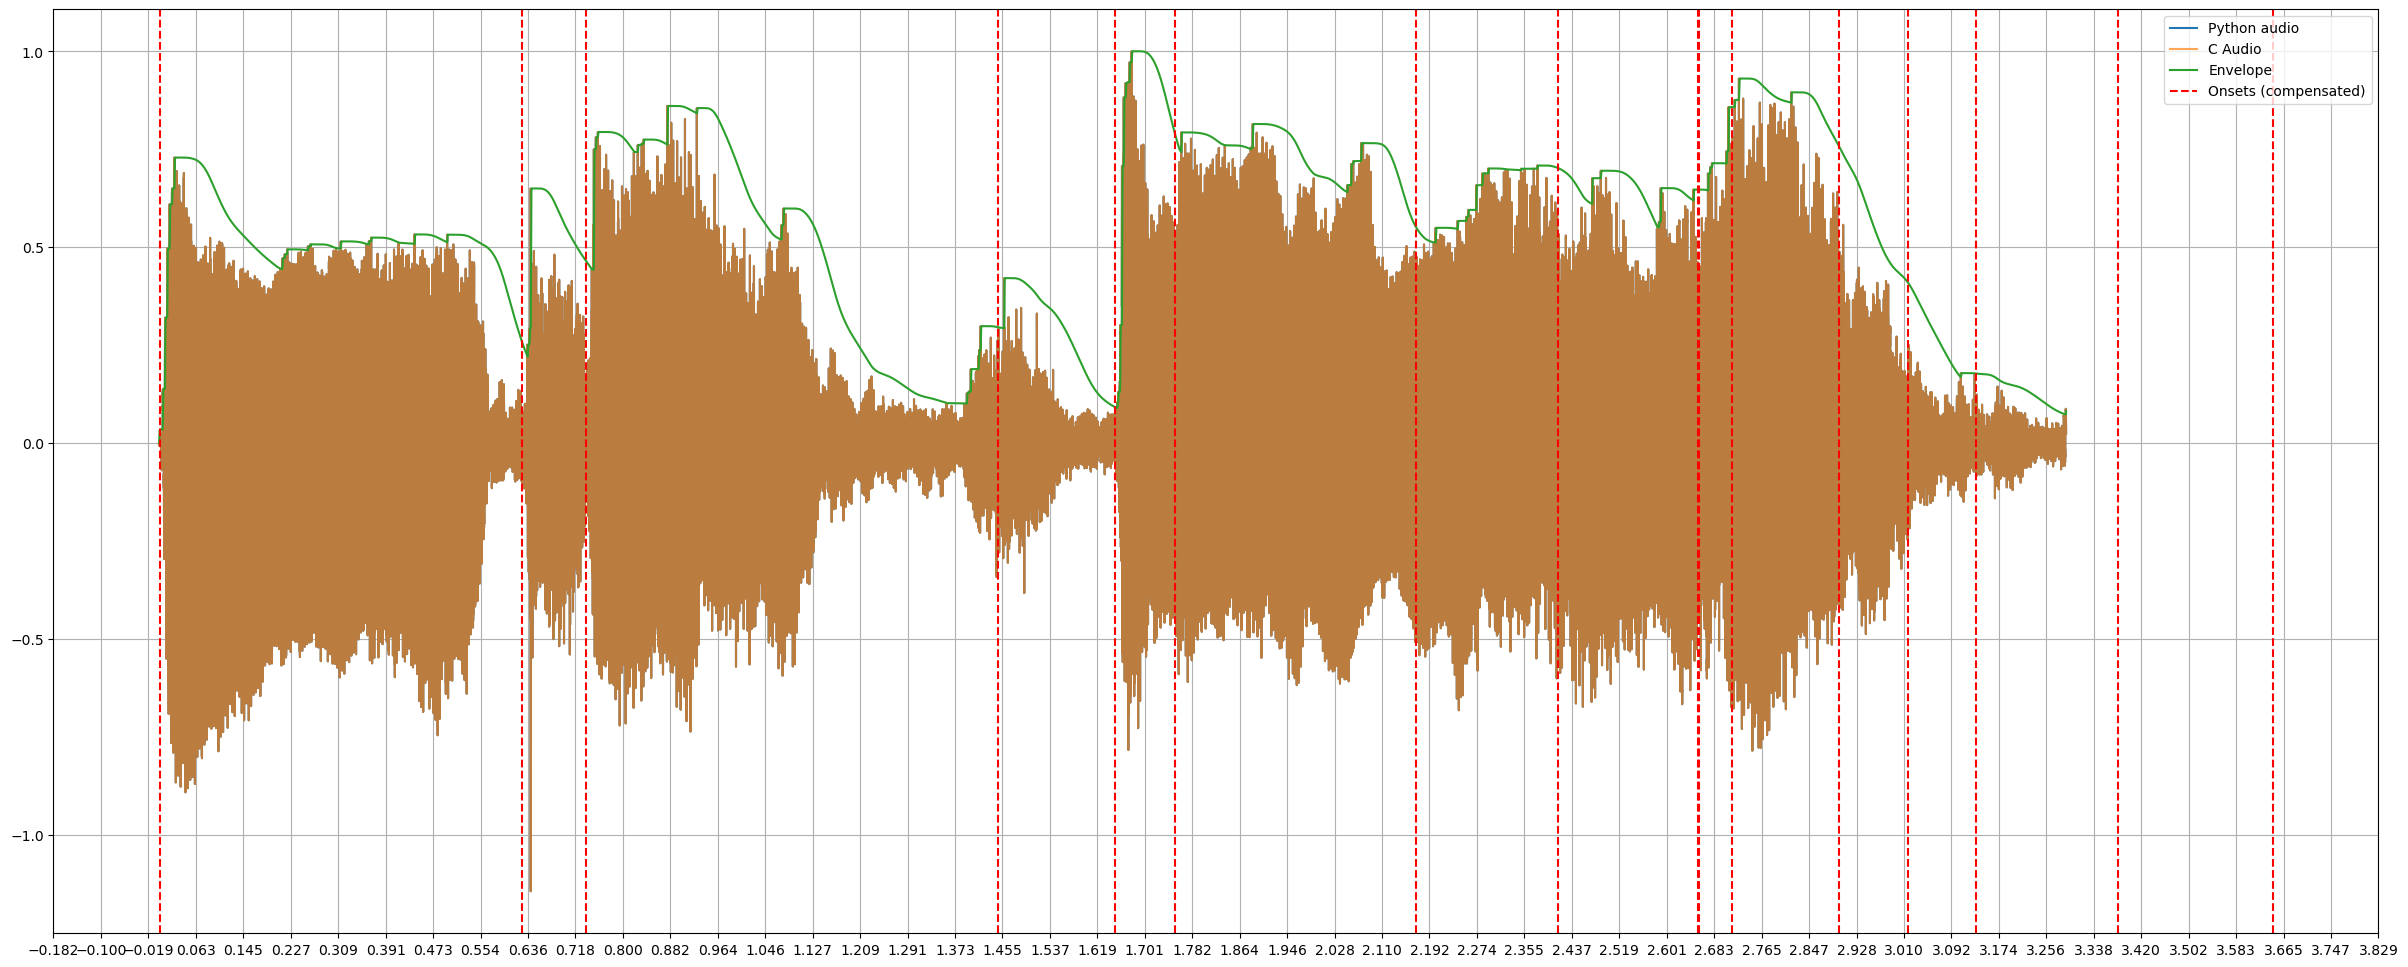

13 - Eli Preiss - Alles und nichts
Tempo:  156.794425087108
TA1:  0.009760416666666667
TA2:  0.17585416666666667
-------
TA1 python percentile:  0.009760416666666667
TA2 python percentile::  0.17585416666666667


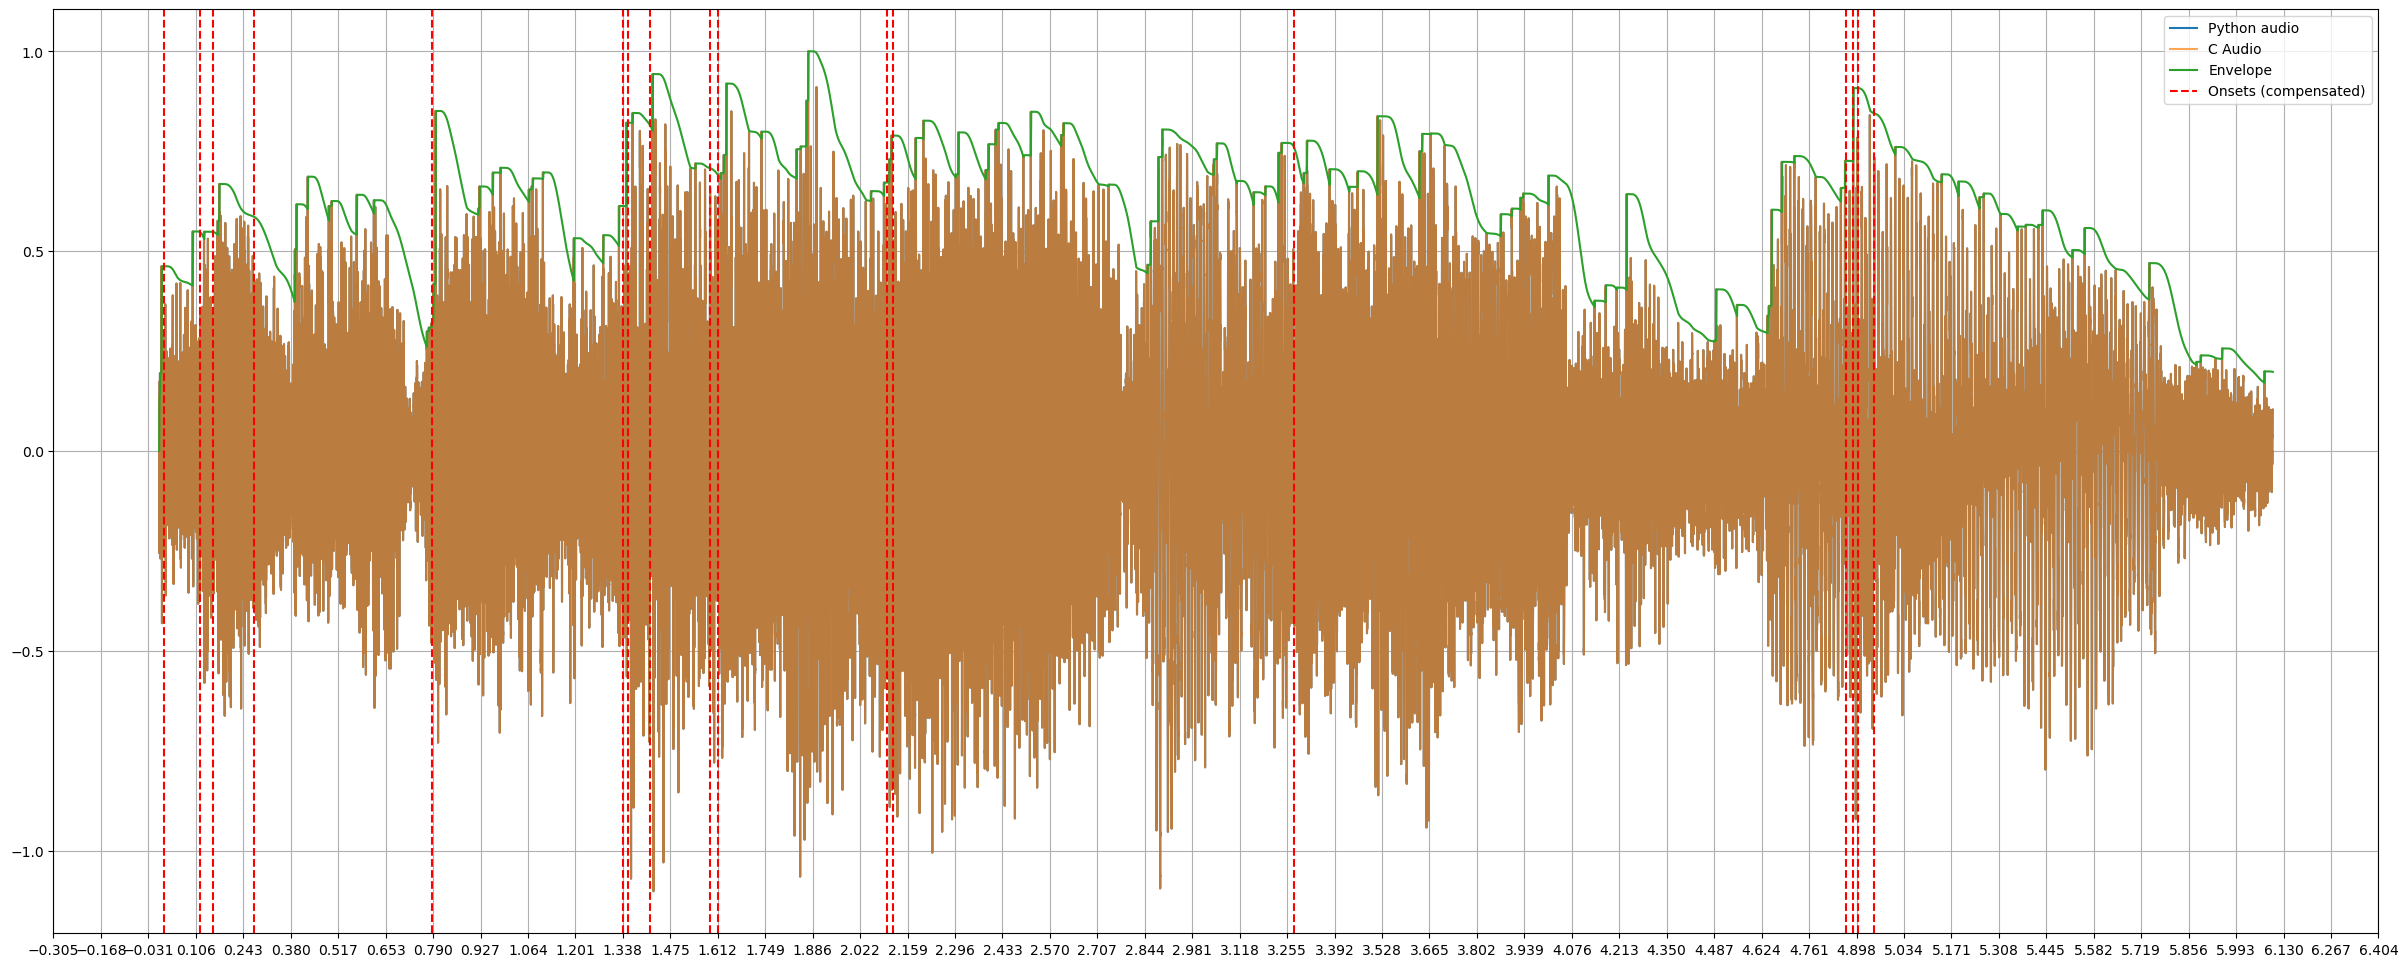

14 - 20221106_GNOSSIENNE No. 1 on GUITAR! (Erik Satie)
Tempo:  152.54237288135593
TA1:  0.0421875
TA2:  0.39336458333333335
-------
TA1 python percentile:  0.016677083333333332
TA2 python percentile::  0.24497916666666666


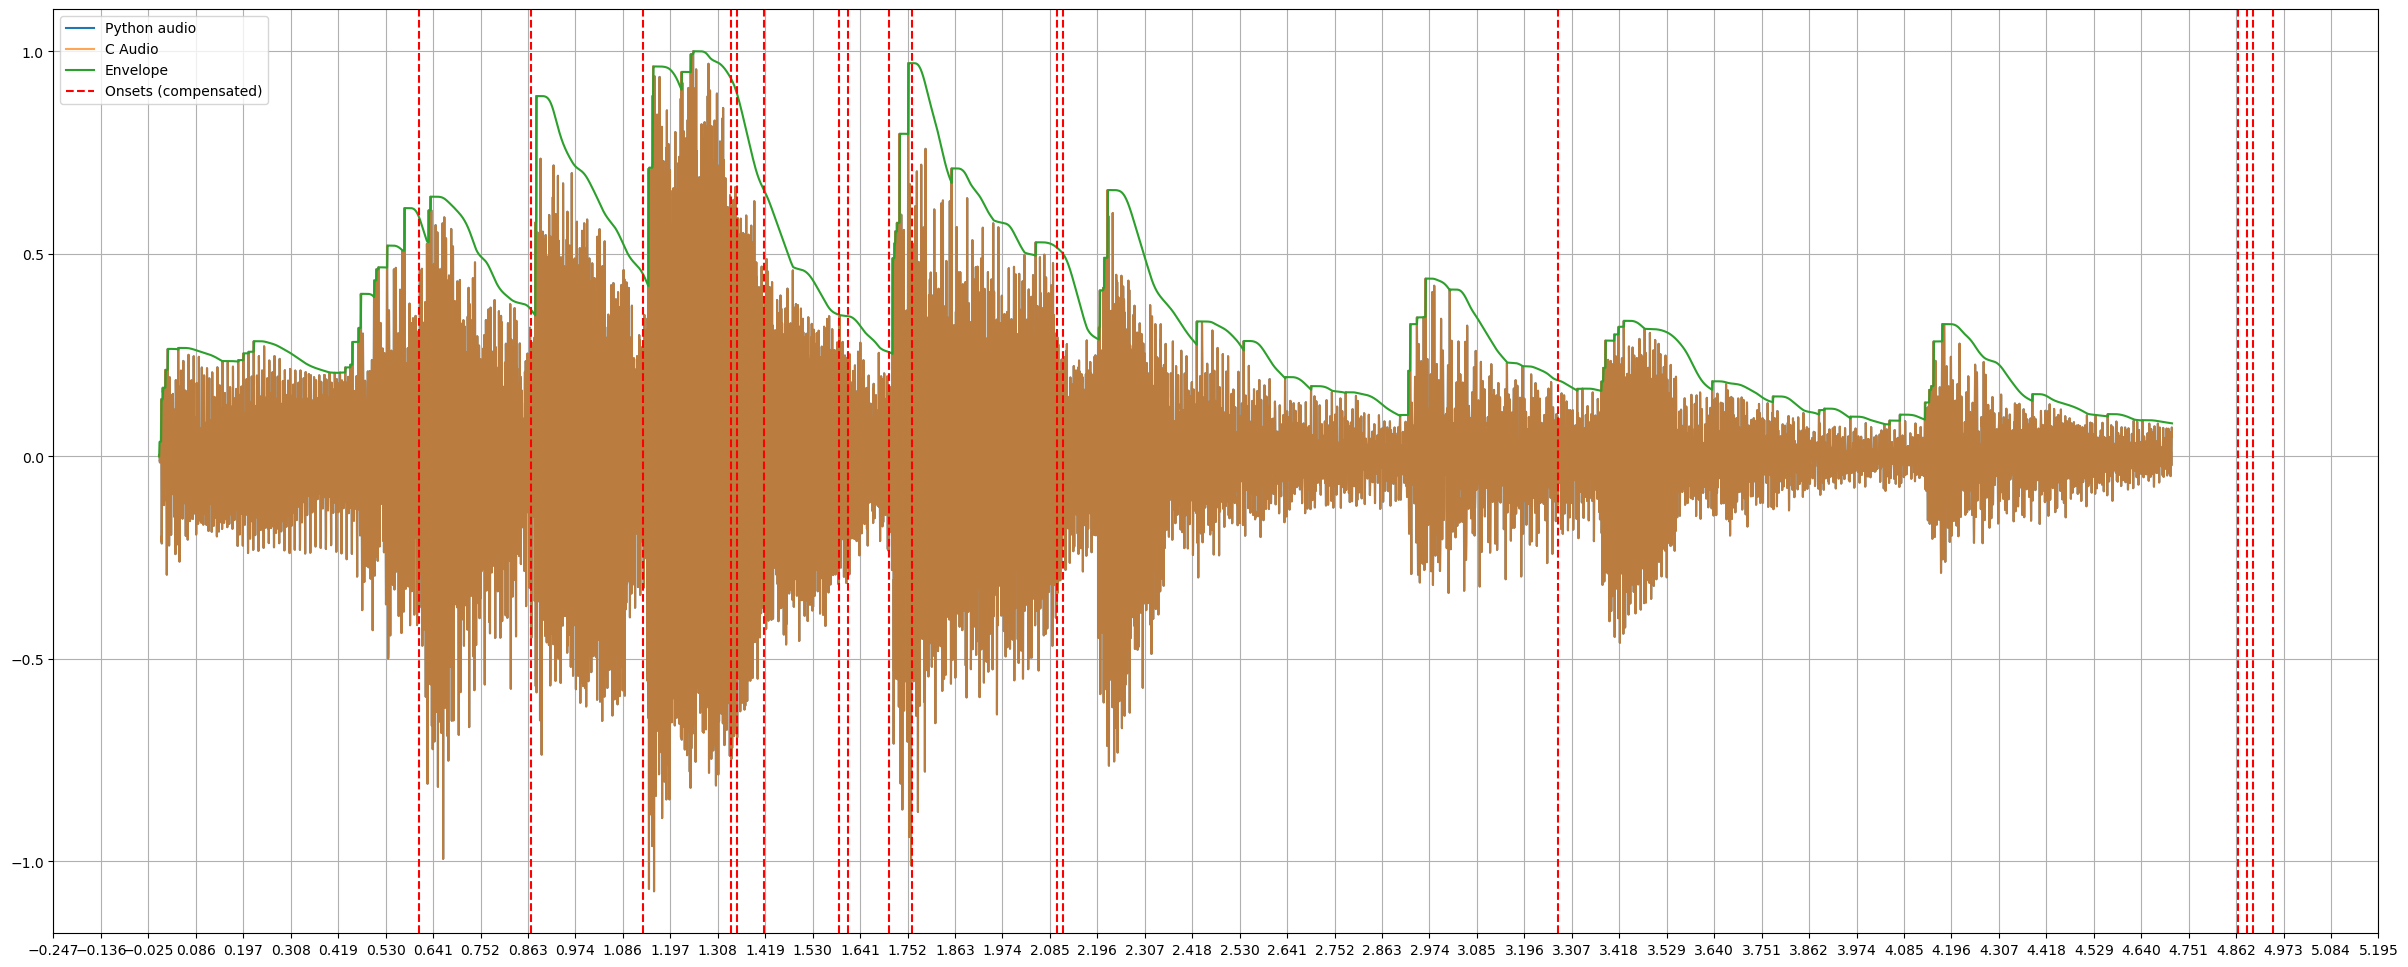

21 - 20230323_100 gecs - Dumbest girl alive lyrics video
Tempo:  150.0
TA1:  0.014979166666666667
TA2:  0.16078125
-------
TA1 python percentile:  0.014619791666666666
TA2 python percentile::  0.15358333333333332


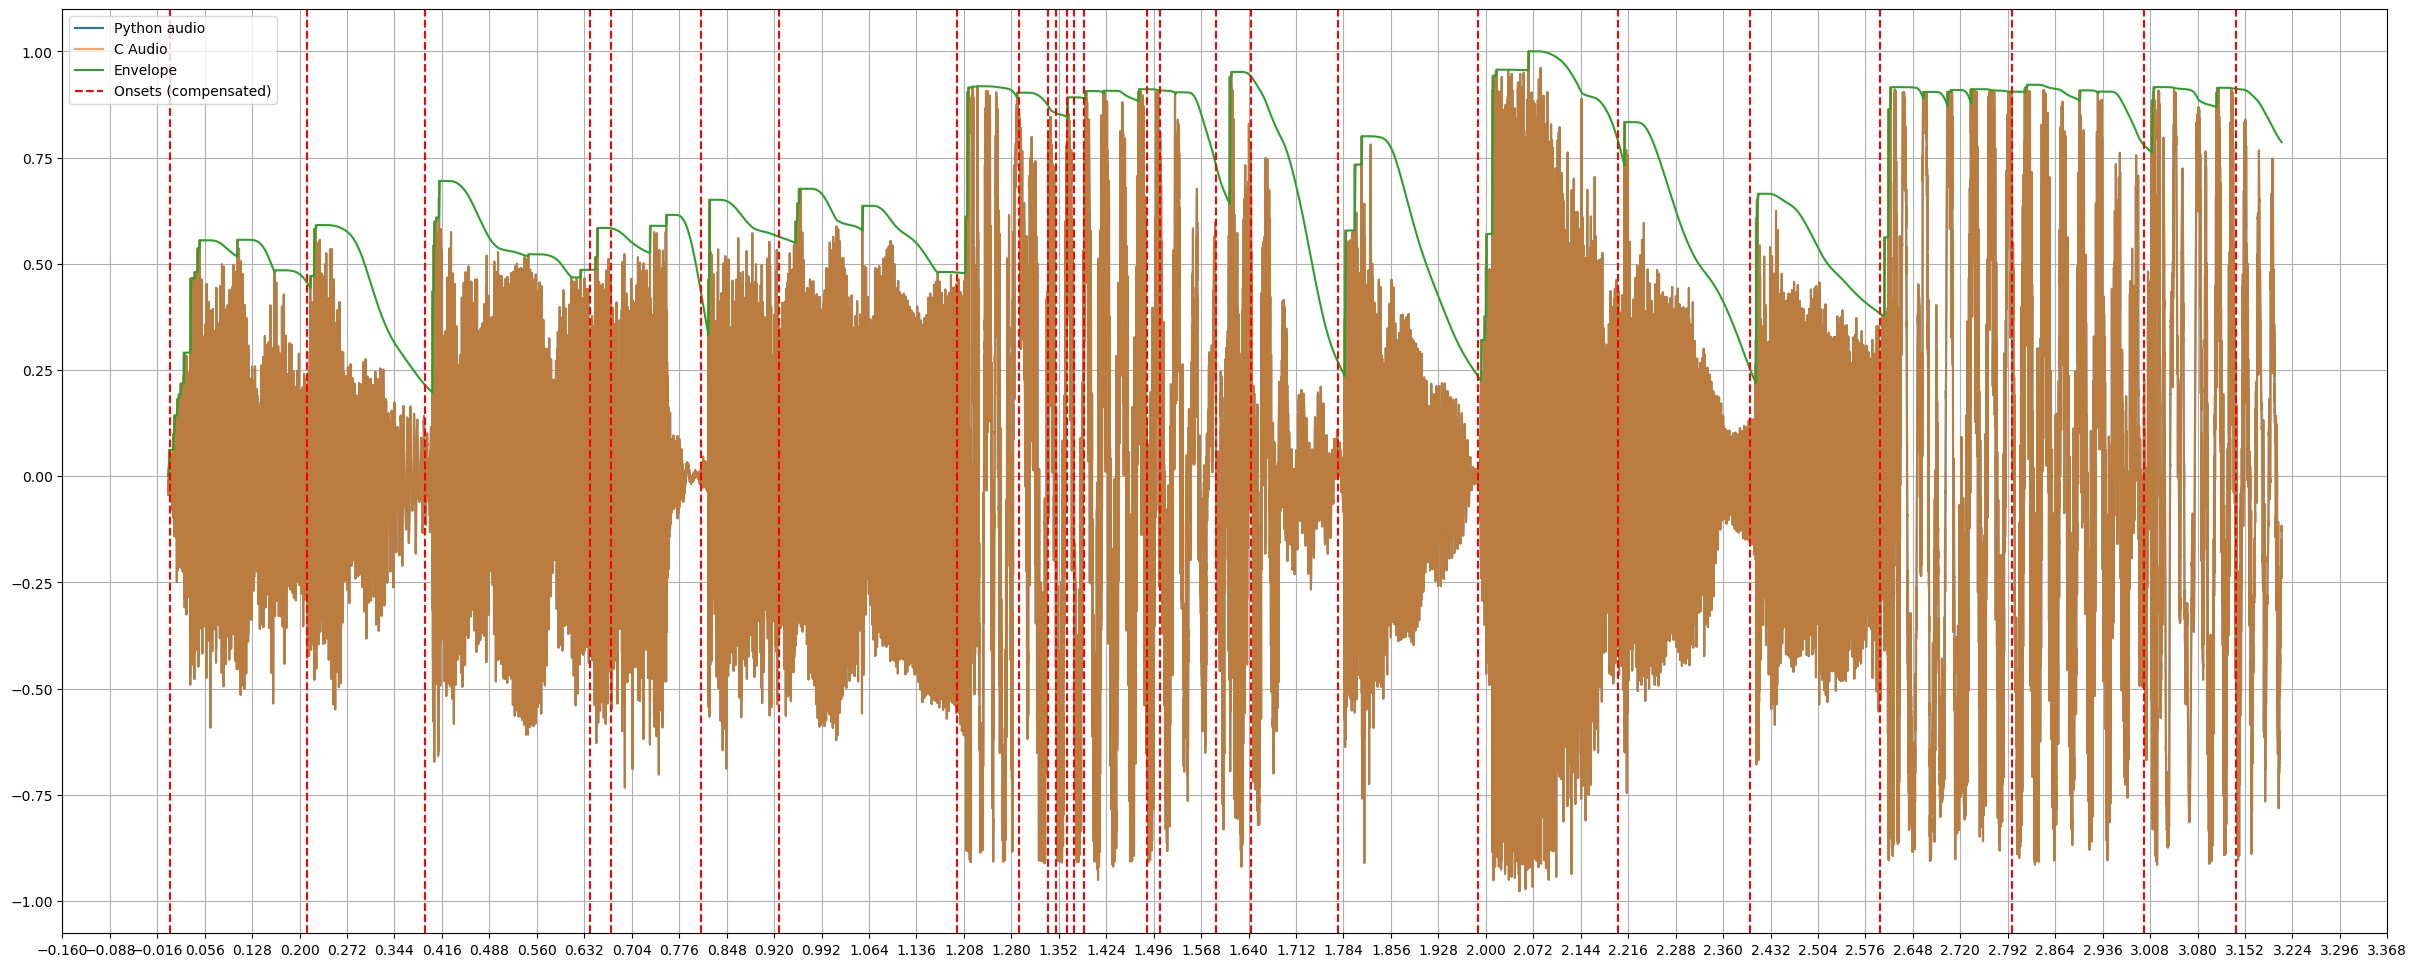

23 - 20220811_Westberlin Bass
Tempo:  150.0
TA1:  0.05732291666666667
TA2:  0.19276041666666666
-------
TA1 python percentile:  0.0576171875
TA2 python percentile::  0.19563802083333331


In [2]:
sampleRate = 96000
BEAT_DETECTION_BUFFER_SIZE = 64
AUDIO_BUFFER_SIZE_S = 8
AUDIO_BUFFER_SIZE = sampleRate * AUDIO_BUFFER_SIZE_S
MAX_ONSETS = 4 * AUDIO_BUFFER_SIZE_S # 4 BPS IS 240 BPM


from ctypes import *
lib = CDLL("../src/af/AFInC.dll")  # Adjust path accordingly

lib.resetBuffer.argtypes = []
lib.resetBuffer.restype = None

lib.initAf.argtypes = []
lib.initAf.restype = None

lib.AFInCAppend.argtypes = [c_double]
lib.AFInCAppend.restype = None

lib.AFInCProcess.argtypes = []
lib.AFInCProcess.restype = None

lib.afGetT1A.argtypes = []
lib.afGetT1A.restype = c_double

lib.afGetT2A.argtypes = []
lib.afGetT2A.restype = c_double

lib.afGetTempo.argtypes = []
lib.afGetTempo.restype = c_double


# ----------------------------------------
# debug helpers
# ----------------------------------------
lib.__getAudioBuffer.argtypes = []
lib.__getAudioBuffer.restype = c_double

lib.__getEnvBuffer.argtypes = []
lib.__getEnvBuffer.restype = c_double

lib.__getOnsetBuffer.argtypes = []
lib.__getOnsetBuffer.restype = c_double

lib.__getTA1Buffer.argtypes = []
lib.__getTA1Buffer.restype = c_double

lib.__getTA2Buffer.argtypes = []
lib.__getTA2Buffer.restype = c_double

lib.__resetIndexDebug.argtypes = []
lib.__resetIndexDebug.restype = None


for song in audio_data_with_labels:
    lib.__resetIndexDebug()

    target_device_audio_buffer = []
    envelope = []
    onsets = []
    TA1Buffer = []
    TA2Buffer = []
    lib.initAf()
    lib.resetBuffer()

    print(song[1])
    for sample in song[0]:
        lib.AFInCAppend(sample)

    lib.AFInCProcess()
    
    print("Tempo: ", lib.afGetTempo())
    print("TA1: ", lib.afGetT1A() / sample_rate)
    print("TA2: ", lib.afGetT2A() / sample_rate)
    print("-------")
    
    for sample in song[0]:
        target_device_audio_buffer.append(lib.__getAudioBuffer())
        envelope.append(lib.__getEnvBuffer())
    
    for onset in range(MAX_ONSETS):
        currentOnset = lib.__getOnsetBuffer()
        if(currentOnset == 0):
            break
        currentTA1 = lib.__getTA1Buffer() / sample_rate
        curretnTA2 = lib.__getTA2Buffer() / sample_rate
        onsets.append(currentOnset)
        TA1Buffer.append(currentTA1)
        TA2Buffer.append(curretnTA2)
        # print("-------")
        #print(currentOnset / sample_rate)
        #print(currentTA1)
        # print(curretnTA2)
        # print("-------")

    print("TA1 python percentile: ", np.percentile(TA1Buffer, 75))
    print("TA2 python percentile:: ", np.percentile(TA2Buffer, 75))

    plt.figure(figsize=(30, 12))
    ax = plt.gca()  # Get the current axes for customization
    ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=50))

    plt.plot([i/sampleRate for i in range(len(song[0]))], song[0], label="Python audio")
    plt.plot([i/sampleRate for i in range(len(target_device_audio_buffer))], target_device_audio_buffer, alpha=0.7, label="C Audio")
    plt.plot([i/sampleRate for i in range(len(envelope))], envelope, label="Envelope")
    for i, onset in enumerate(onsets):
        if int(onset) != 0:
            if i == 0:
                plt.axvline(x=int(onset)/sampleRate, color='r', linestyle='--', label="Onsets (compensated)")
            else:
                plt.axvline(x=int(onset)/sampleRate, color='r', linestyle='--')
        
    plt.legend()
    plt.grid()
    plt.show()
